# Data Processing

This notebook contains a workflow to:
1. Download hourly ERA5 data from a Google Cloud Storage bucket.
1. Process the hourly ERA5 data into daily ERA5 data.
1. Upload the daily data to a Google Cloud Storage bucket.

This data processing is necessary to support an analysis of Earth's radiation budget based on daily solar fluxes at the surface and top of atmosphere, so we will process hourly averages into daily averages. ERA5 does not output top of atmosphere outgoing solar radiation or upwelling solar radiation at the surface, however these quantities can be calculated using the available fluxes at those levels (e.g. incoming radiation and net radiation at the top of atmosphere).

### Requirements

* A Google Cloud project with Cloud Storage enabled
* The following Python packages:

In [ ]:
%pip install -q gsutil tqdm xarray scipy dask netCDF4 pandas joblib

## Imports

In [62]:
import contextlib
from datetime import timedelta, date, datetime
from os import system

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import joblib
from joblib import Parallel, delayed
import xarray as xr

xr.set_options(keep_attrs=True)

## Setup

Our analysis seeks a long-term estimate of the amount of outgoing radiation that Earth's surface can reflect. ERA5 has 42 years of hourly data available. A long-term climatology is typically defined as 30 years. Thus, we ingest the latest 30 years: 1991 through 2020. Since making a single request would be prohibitively large, we break the request up by day. 

In [61]:
start_date = date(1991, 5, 1)
end_date = date(1991, 6, 1)
hourly_data_bucket = "era5-single-level"
daily_data_bucket = "era5-single-level-daily"

## Functions

In [ ]:
@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Patch joblib to report into tqdm progress bar given as argument."""

    def tqdm_print_progress(self):
        if self.n_completed_tasks > tqdm_object.n:
            n_completed = self.n_completed_tasks - tqdm_object.n
            tqdm_object.update(n=n_completed)

    original_print_progress = joblib.parallel.Parallel.print_progress
    joblib.parallel.Parallel.print_progress = tqdm_print_progress

    try:
        yield tqdm_object
    finally:
        joblib.parallel.Parallel.print_progress = original_print_progress
        tqdm_object.close()


def daterange(start_date, end_date):
    """Make a date range object spanning two dates.
    
    Args:
      start_date: date object to start from.
      end_date: date object to end at.
    
    Yields:
      date object for iteration.
    """
    for n in range(int ((end_date - start_date).days)):
        yield start_date + timedelta(n)


def get_date_data_gcs(single_date, bucket):
    """Download a dataset for a single date from Google Cloud Storage.
    
    Args:
        single_date: date object representing day to retrieve data for.
        bucket: Google Cloud Storage bucket to download from.
        
    Returns:
        Exit status of system call to get data.
    """
    download_status = system(f"gsutil -m cp -r gs://{bucket}/{single_date.strftime('%Y%m%d')}.nc \
                             {single_date.strftime('%Y%m%d')}.nc")
    return download_status


def put_date_data_gcs(single_date, bucket, cleanup=False):
    """Upload a dataset for a single date to Google Cloud Storage.
    
    Args:
        single_date: date object representing day to retrieve data for.
        bucket: Google Cloud Storage bucket to download from.
        cleanup: Optionally remove the file locally.
        
    Returns:
        Nothing; downloads data from Google Cloud Storage as side effect.
    """
    upload_status = system(f"gsutil -m cp -r {single_date.strftime('%Y%m%d')}.nc gs://{bucket}/")
    
    if (upload_status == 0) & cleanup:
        system(f"rm {single_date.strftime('%Y%m%d')}.nc")

    return upload_status


def modify_units(dataset, starting_unit, ending_unit, conversion_factor)
    """Modify the units of a variable"""

def compute_daily_average(dataset):
    """Compute the daily average and an input dataset"""
    
    
def process_hourly_data(single_date, hourly_bucket, daily_bucket, cleanup=False):
    """Process hourly average data into daily average data."""
    get_date_data_gcs(single_date, hourly_bucket)
    
    with xr.open_dataset(f"./{single_date.strftime('%Y%m%d')}.nc") as ds:
        ds

    put_date_data_gcs(single_date, hourly_bucket)


In [44]:
era5 = xr.open_dataset("./19910101.nc",
                       engine="netcdf4",
                       chunks={"time": 24,
                               "latitude": 721,
                               "longitude": 1440})

In [51]:
era5

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, time: 1)
Coordinates:
  * time       (time) datetime64[ns] 1991-01-01
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
Data variables:
    ssrd       (time, latitude, longitude) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    tisr       (time, latitude, longitude) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    ssr        (time, latitude, longitude) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    tsr        (time, latitude, longitude) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2021-06-03 18:12:12 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

In [56]:
era5["tosr"] = era5["tisr"] - era5["tsr"]
era5.tosr.attrs
era5["ssru"] = era5["ssrd"] - era5["ssr"]

In [57]:
era5.tosr.attrs

{'units': 'W m**-2', 'long_name': 'TOA incident solar radiation'}

In [58]:
era5

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, time: 1)
Coordinates:
  * time       (time) datetime64[ns] 1991-01-01
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
Data variables:
    ssrd       (time, latitude, longitude) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    tisr       (time, latitude, longitude) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    ssr        (time, latitude, longitude) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    tsr        (time, latitude, longitude) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    tosr       (time, latitude, longitude) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    ssru       (time, latitude, longitude) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2021-06-03 18:12:12 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

In [46]:
era5.tisr.attrs

{'units': 'J m**-2', 'long_name': 'TOA incident solar radiation'}

In [47]:
era5 = era5.resample(time='1D').sum() / (60 * 60 * 24)

In [49]:
era5.tisr.attrs["units"] = "W m**-2"

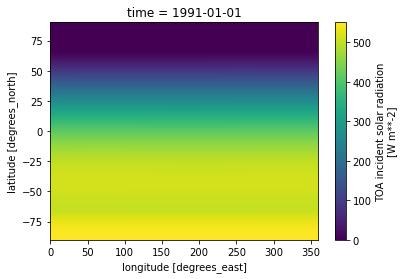

In [50]:
era5.tisr[0, :, :].plot.imshow()

In [9]:
era5.to_netcdf(path="./19900101_daily.nc")

In [ ]:
system(f"gsutil -m cp -r ./19900101_daily.nc gs://19900101.nc")